# SET-UP

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

# Dataset

**Modifi: Bộ dữ liệu UTKFace sử dụng để huấn luyện các mô hình học máy trong việc nhận dạng tuổi, giới tính và sắc tộc từ ảnh khuôn mặt. Hơn 23000 bức ảnh**

In [3]:
from skimage import io, transform
class UTKFaceDataset(Dataset):
    def __init__(self, dataset_path, transform = None):
        self.dataset_path = dataset_path
        self.transform = transform
        images = []
        genders = []
        ages = []
        for i in os.listdir(self.dataset_path)[0:20000]:  #25000
            split = i.split('_')
            ages.append(int(split[0]))
            genders.append(int(split[1]))
            images.append(os.path.join(self.dataset_path, i))
        self.df = pd.DataFrame({"Image": images, "Genders": genders, "Ages": ages})
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        image = io.imread(self.df.iloc[index]["Image"])
        label = self.df.iloc[index]["Genders"]
        if self.transform:
            image = self.transform(image)
        return image, label
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((64,64),       #PyTorch 64x64 pixels.
        antialias = True)
    ]
)

dataset = UTKFaceDataset('/kaggle/input/utkface-new/UTKFace', transform)

In [4]:
#devide dataset
indices = [i for i in range(len(dataset))]

train_val_indices, test_indices = train_test_split(indices, test_size = 0.4, random_state = 31) #60/40

train_indices, val_indices = train_test_split(train_val_indices, test_size = 0.3, random_state = 31) #70/30


In [5]:
#Modified shuffle = True xáo dữ liệu cho đa dạng
batch_size = 64
train_loader = DataLoader(torch.utils.data.Subset(dataset,train_indices),
                          batch_size=batch_size, shuffle = True)
val_loader = DataLoader(torch.utils.data.Subset(dataset,val_indices),
                        batch_size=batch_size, shuffle = False)
test_loader = DataLoader(torch.utils.data.Subset(dataset,test_indices),
                         batch_size=batch_size, shuffle = False)

In [6]:
print(f"Dataset: {len(indices)}")
print(f"Số lượng tập train: {len(train_val_indices)}")
print(f"Số lượng mẫu trong tập test: {len(test_indices)}")
print(f"Số lượng mẫu trong tập train để train: {len(train_indices)}")
print(f"Số lượng mẫu trong tập train để validation: {len(val_indices)}")
print(f"Số lượng batch trong tập train: {len(train_loader)}")
print(f"Số lượng batch trong tập validation: {len(val_loader)}")
print(f"Số lượng batch trong tập test: {len(test_loader)}")

Dataset: 20000
Số lượng tập train: 12000
Số lượng mẫu trong tập test: 8000
Số lượng mẫu trong tập train để train: 8400
Số lượng mẫu trong tập train để validation: 3600
Số lượng batch trong tập train: 132
Số lượng batch trong tập validation: 57
Số lượng batch trong tập test: 125


In [7]:
def get_random_images(dataset, N):   #Lấy ảnh ngẫu nhiên và nhãn tương ứng
    images = []
    labels = []
    image_index = n.random.choice([i for i in range(len(dataset))],
                                    size = N,
                                    replace = False)
    for i in image_index:
      images.append(dataset[i][0])
      labels.append(dataset[i][1])
    return torch.stack(images), labels

def plot_images(images, figsize=(15, 15)):
    fig, axes = plt.subplots(6, 6, figsize=figsize)
    for idx, ax in enumerate(axes.flat):
        ax.imshow(images[idx].permute(1, 2, 0))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def get_random_images(dataset, N):
    images = []
    labels = []
    image_index = np.random.choice(range(len(dataset)), size=N, replace=False)
    for i in image_index:
        images.append(dataset[i][0])
        labels.append(dataset[i][1])
    return images, labels

Size of images : torch.Size([3, 64, 64])


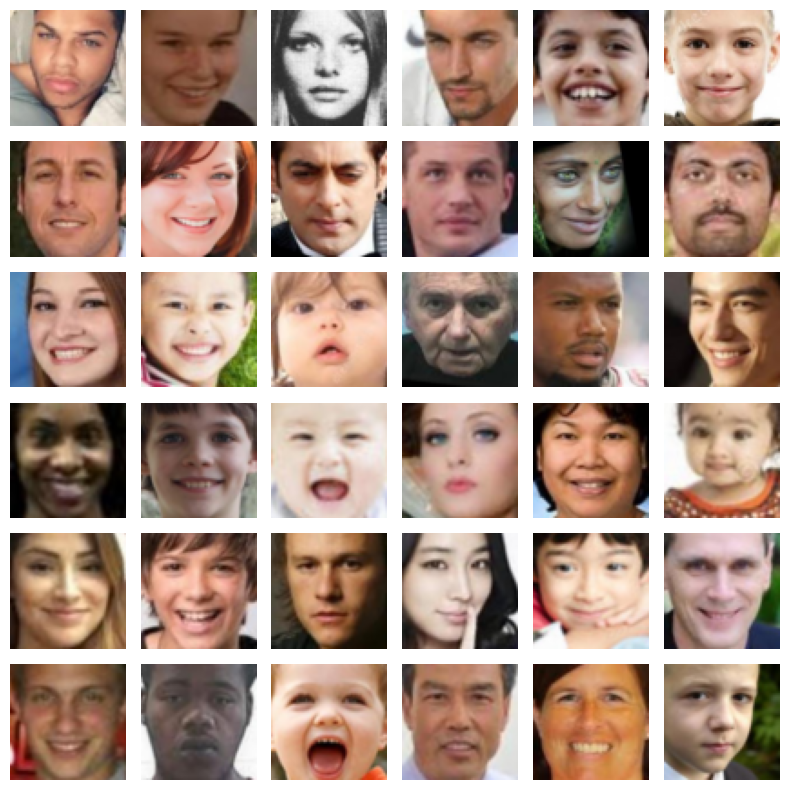

In [8]:
import matplotlib.pyplot as plt
print(f"Size of images : {dataset[0][0].size()}")
images, labels = get_random_images(dataset, 36)
plot_images(images, figsize=(8, 8))  # Đặt kích thước lớn hơn tại đây

# AutoEncoder

Bộ mã hóa (encoder_conv)

ConvolutionalBlock: Bộ mã hóa bắt đầu với một lớp tích chập (Conv2d) với 3 kênh đầu vào (RGB) và 32 kênh đầu ra. Kích thước kernel là (3, 3) và được áp dụng ReLU activation function sau đó. Sau đó, dữ liệu đi qua một lớp chuẩn hóa theo batch (BatchNorm2d).
MaxPool2d.DenseBlock: Cấu trúc này kết hợp nhiều lớp DenseLayer. Mỗi lớp DenseLayer gồm một lớp tích chập, một ReLU activation function và một lớp chuẩn hóa theo batch.
ConvolutionalBlock: Một lớp tích chập khác để biến đổi dữ liệu thành biểu diễn nén cuối cùng.

Bộ giải mã (decoder_conv)

TransposeConvolutionalBlock: Bắt đầu với ConvTranspose2d để tăng kích thước. Lớp này sử dụng ReLU activation function và chuẩn hóa theo batch.
ConvTranspose2d: Lớp tích chập chuyển vị cuối cùng để tái tạo lại ảnh gốc. Lớp này có 3 kênh đầu ra tương ứng với 3 kênh màu của ảnh RGB và sử dụng hàm kích hoạt Sigmoid để đảm bảo đầu ra nằm trong khoảng [0, 1].

In [9]:
class DenseBlock(nn.Module):             #desenLayer được kết nối với nhau
    def __init__(self, channels):    
        super(DenseBlock, self).__init__()  
        self.Dense_Layers = nn.Sequential(       
            DenseLayer(channels * 1 , channels),
            DenseLayer(channels * 2 , channels),
            DenseLayer(channels * 3 , channels) 
        )
        self.Conv_1x1 = nn.Conv2d(channels * 4, channels,  #tích chập conv2d -> ReLU ->BatchNorm2d, output Conv_1x1
                                  kernel_size = 1, 
                                  padding = 0)
        
    def forward(self, x):     
        out = self.Dense_Layers(x) 
        out = self.Conv_1x1(out)    
        return out
    
class DenseLayer(nn.Module):   #tích chập ReLU và chuẩn hóa batch
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()    
        self.Dense_Layer = nn.Sequential(       
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels) 
            
        )
        
    def forward(self,x):     
        out = torch.cat([x, self.Dense_Layer(x)], dim = 1)     
        return out

class ConvolutionalBlock(nn.Module):    #một tầng tích chập, ReLU và chuẩn hóa batch.
    def __init__(self, in_channels, out_channels):
        super(ConvolutionalBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels,
                              out_channels,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        return x

class TransposeConvolutionalBlock(nn.Module):   # ConvTranspose2d để thực hiện quá trình upsampling trong bộ giải mã của mô hình tự mã hóa
    def __init__(self, in_channels, out_channels):
        super(TransposeConvolutionalBlock, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels,
                                       out_channels,
                                       kernel_size = 3,
                                       stride = 2,
                                       output_padding = 1,
                                       padding = 1)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        return x

class Autoencoder(nn.Module):  #ConvolutionalBlock và DenseBlock cùng với MaxPool2d để giảm kích thước không gian và tăng độ phức tạp
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 3 x 64 x 64  ảnh ban đầu 64x64 và 3 RGB
        # 32 x 32 x 32  32 channel 32x32 px
        # 64 x 16 x 16
        # 128 x 8 x 8
        self.encoder_conv = nn.Sequential(
            ConvolutionalBlock(3, 32),
            nn.MaxPool2d(kernel_size = 2),  
            DenseBlock(32),
            
            ConvolutionalBlock(32, 64),
            nn.MaxPool2d(kernel_size = 2),

            DenseBlock(64),

            ConvolutionalBlock(64, 128),
            nn.MaxPool2d(kernel_size = 2)
        )

        # 128 x 8 x 8  128 channel 8x8 pixel
        # 64 x 16 x 16 64 channel 16x16 px
        # 32 x 32 x 32 32 channel 32x32 px
        # 3 x 64 x 64 ảnh ban đầu 64x64 và 3 RGB
        self.decoder_conv = nn.Sequential( 
            TransposeConvolutionalBlock(128, 64), #tăng kích thước không gian trở lại và một phép tích chập đảo ConvTranspose2d

            TransposeConvolutionalBlock(64, 32),
    
            nn.ConvTranspose2d(32, 3,
                               kernel_size = 3,
                               stride = 2,
                               output_padding = 1,
                               padding = 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.decoder_conv(x)
        return x
    
model_ae = Autoencoder().to(device)

print(model_ae)

Autoencoder(
  (encoder_conv): Sequential(
    (0): ConvolutionalBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): DenseBlock(
      (Dense_Layers): Sequential(
        (0): DenseLayer(
          (Dense_Layer): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): DenseLayer(
          (Dense_Layer): Sequential(
            (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        

In [10]:
#train_model: Hàm này nhận vào mô hình (model), bộ tải dữ liệu huấn luyện và kiểm định (train_loader và val_loader),
#    tiêu chí tổn thất (criterion), tối ưu hóa (optimizer), và số lượng epochs
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        #lan truyền xuôi và lan truyền ngược để cập nhật trọng số mô hình
        #loss.backward() để tính gradient và optimizer.step() để cập nhật trọng số
        for i, (images, gender_labels) in enumerate(train_loader): 
            optimizer.zero_grad()
            images, gender_labels = images.to(device), gender_labels.to(device)
            reconstruction = model(images)
            loss = criterion(reconstruction, images)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval() #tắt chuẩn hóa batch và dropout
        running_val_loss = 0.0
        #Lặp qua dữ liệu kiểm định mà không cần tính gradient
        with torch.no_grad():
          for i, (images, gender_labels) in enumerate(val_loader):
                images, gender_labels = images.to(device), gender_labels.to(device)
                reconstruction = model(images)
                loss = criterion(reconstruction, images)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Epoch [1/20], Train Loss: 0.014717, Val Loss: 0.011938
Epoch [2/20], Train Loss: 0.006854, Val Loss: 0.008934
Epoch [3/20], Train Loss: 0.004881, Val Loss: 0.008477
Epoch [4/20], Train Loss: 0.004273, Val Loss: 0.004827
Epoch [5/20], Train Loss: 0.003765, Val Loss: 0.003919
Epoch [6/20], Train Loss: 0.003696, Val Loss: 0.006372
Epoch [7/20], Train Loss: 0.003306, Val Loss: 0.007358
Epoch [8/20], Train Loss: 0.003176, Val Loss: 0.003757
Epoch [9/20], Train Loss: 0.002998, Val Loss: 0.002769
Epoch [10/20], Train Loss: 0.002546, Val Loss: 0.002184
Epoch [11/20], Train Loss: 0.002298, Val Loss: 0.004117
Epoch [12/20], Train Loss: 0.002470, Val Loss: 0.002024
Epoch [13/20], Train Loss: 0.002460, Val Loss: 0.002224
Epoch [14/20], Train Loss: 0.002251, Val Loss: 0.003393
Epoch [15/20], Train Loss: 0.002210, Val Loss: 0.004937
Epoch [16/20], Train Loss: 0.002027, Val Loss: 0.002643
Epoch [17/20], Train Loss: 0.002021, Val Loss: 0.002391
Epoch [18/20], Train Loss: 0.001922, Val Loss: 0.003926
E

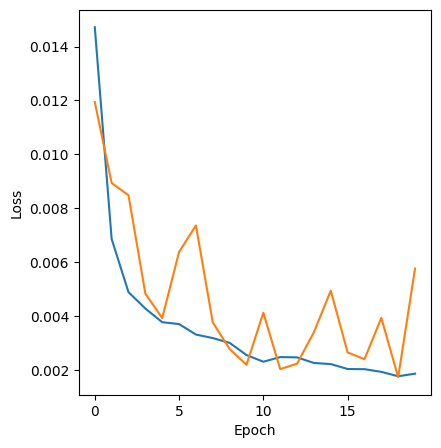

In [11]:
criterion = nn.MSELoss() # hàm tổn thất Bình phương sai lệch trung bình (Mean Squared Error Loss)
optimizer = optim.Adam(model_ae.parameters(), lr = 0.1)  #tính toán gradient  
train_model(model_ae, train_loader, val_loader, criterion, optimizer, num_epochs = 20)

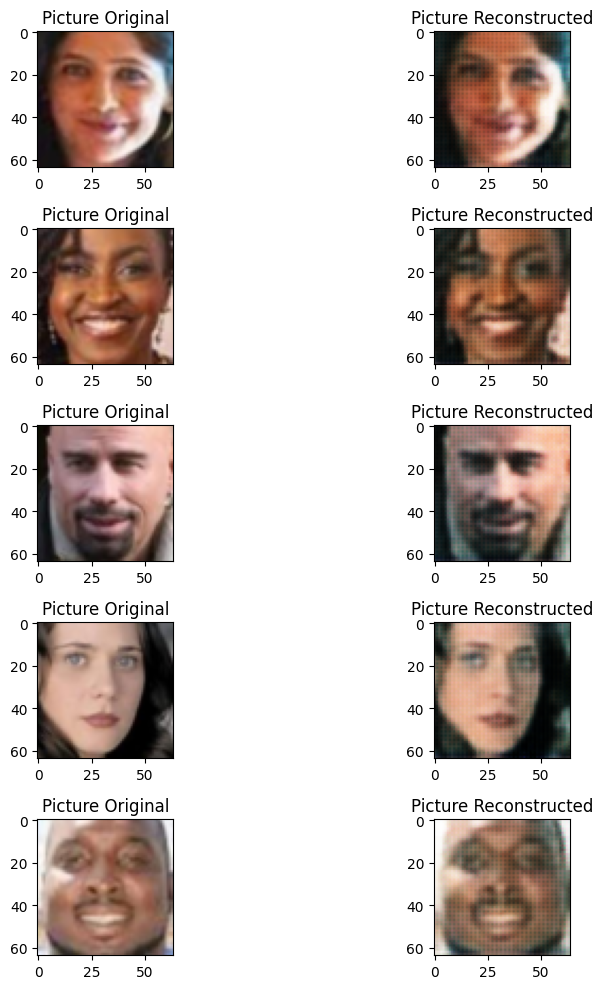

In [12]:
#hiển thị ảnh gốc và reconstructed images
def visualize_reconstructions(model, test_loader, device, num_images=5):
    model.eval()
    with torch.no_grad(): #Tắt tính toán gradient giúp giảm thiểu bộ nhớ và tăng tốc độ tính toán
        fig, axes = plt.subplots(num_images, 2, figsize=(10, 2*num_images))
        for i, (data, _) in enumerate(test_loader):
            if i == num_images:
                break
            original_img = data[0].permute(1, 2, 0).cpu().numpy()  # Original image H x W x C
            reconstructed_img = model(data.to(device))
            reconstructed_img = reconstructed_img[0].permute(1, 2, 0).cpu().numpy()  # Reconstructed image
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title('Picture Original')
            axes[i, 1].imshow(reconstructed_img)
            axes[i, 1].set_title('Picture Reconstructed')
        plt.tight_layout()
        
        plt.show()

# Assuming you have already instantiated the model and loaded the test dataset
# model = VariationalAutoEncoder(latent_vector_size).to(device)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

visualize_reconstructions(model_ae, test_loader, device)

# Variational Autodecoder

In [13]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dimension = 64):
        super(VariationalAutoencoder, self).__init__()
        # 3 x 64 x 64 
        # 32 x 32 x 32
        # 64 x 16 x 16
        # 128 x 8 x 8
        self.encoder_conv = nn.Sequential(
            ConvolutionalBlock(3, 32),
            nn.MaxPool2d(kernel_size = 2),
            DenseBlock(32),
            ConvolutionalBlock(32, 64),
            nn.MaxPool2d(kernel_size = 2),
            DenseBlock(64),
            ConvolutionalBlock(64, 128),
            nn.MaxPool2d(kernel_size = 2)
        )
        # 128 x 8 x 8
        # 64 x 16 x 16
        # 32 x 32 x 32
        # 3 x 64 x 64
        self.decoder_conv = nn.Sequential(
            TransposeConvolutionalBlock(128, 64),

            TransposeConvolutionalBlock(64, 32),
            
            nn.ConvTranspose2d(32, 3,
                               kernel_size = 3,
                               stride = 2,
                               output_padding = 1,
                               padding = 1),
            nn.Sigmoid()
        )
        # Latent Space
        self.mean = nn.Linear(128 * 8 * 8, latent_dimension)  # + trả về 2 giá trị trong hàm forward mean và log variance
        self.log_var = nn.Linear(128 * 8 * 8, latent_dimension)
        self.flatten = nn.Flatten() #chuyển đổi dữ liệu giữa không gian ảnh và không gian vector phẳng, 
                                    #điều này cần thiết để xử lý dữ liệu trong không gian ẩn
        self.unflatten = nn.Sequential(
            nn.Linear(latent_dimension, 128 * 8 * 8),
            nn.Unflatten(1, (128, 8, 8))
            
        )
    def reparameterization_trick(self, mean, log_var):    # tạo dữ liệu mới mà vẫn duy trì được khả năng tính toán gradient.
        epsilon = torch.randn_like(log_var).to(mean.device) # Tạo ngẫu nhiên từ (N(0,1)) ảnh cùng kích thước với log_var
        z = mean + log_var * epsilon  #điểm dữ liệu mới z trong không gian ẩn lấy mẫu từ phân phối có mean và variance, chuyển phương sai thành đlc
        return z

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        mean = self.mean(x)     # thêm bước xử lý không gian ẩn thông qua việc tính toán mean và độ lệch chuẩn của data log variance
        log_var = self.log_var(x)
        x = self.reparameterization_trick(mean, torch.exp(0.5 * log_var)) #tối ưu hóa và tạo dữ liệu   
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x, mean, log_var

model_vae = VariationalAutoencoder().to(device)

print(model_vae)

VariationalAutoencoder(
  (encoder_conv): Sequential(
    (0): ConvolutionalBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): DenseBlock(
      (Dense_Layers): Sequential(
        (0): DenseLayer(
          (Dense_Layer): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): DenseLayer(
          (Dense_Layer): Sequential(
            (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
       

In [14]:
#reconstruction loss và KL divergence loss để sinh ra dữ liệu mới đồng thời giữ được cấu trúc của không gian
def loss_function(input, reconstructed, mu, log_sigma): 
    #Tinh sự khác biệt giữa dữ liệu đầu vào và reconstructed bằng cách sử dụng Mean Squared Error (MSE) Loss
    reconstruction_loss = nn.MSELoss(reduction='sum')(reconstructed, input) 
    #ullback-Leibler divergence loss để giúp đảm bảo rằng không gian ẩn của mô hình tiệm cận với phân phối chuẩn Gauss
    kl_divergence = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp())
    return reconstruction_loss + kl_divergence

In [15]:
criterion = loss_function
optimizer = optim.Adam(model_vae.parameters(), lr = 0.0001)

In [16]:
#Cập nhật trọng số của mô hình để giảm thiểu tổn thất trên tập dữ liệu huấn luyện
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        input_data, _ = batch
        input_data = input_data.to(device)

        optimizer.zero_grad()
        reconstructed, mu, log_sigma = model(input_data)
        loss = loss_function(input_data, reconstructed, mu, log_sigma)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss

def validate(model, val_loader, device): #Tính toán tổn thất trên tập dữ liệu kiểm val
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for val_batch in val_loader:
            val_data, _ = val_batch
            val_data = val_data.to(device)
            val_reconstructed, val_mu, val_log_sigma = model(val_data)
            val_loss = loss_function(val_data, val_reconstructed, val_mu, val_log_sigma)

            total_loss += val_loss.item()

    avg_loss = total_loss / len(val_loader.dataset)
    return avg_loss

def test(model, test_loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for test_batch in test_loader:
            test_data, _ = test_batch
            test_data = test_data.to(device)
            test_reconstructed, test_mu, test_log_sigma = model(test_data)
            test_loss = model.loss_function(test_data, test_reconstructed, test_mu, test_log_sigma)

            total_loss += test_loss.item()

    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

def train_vae(model, train_loader, val_loader, optimizer, num_epochs, device="cpu"):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, device)
        val_loss = validate(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # vẽ the training and validation loss curves
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Train the VAE model

Epoch [1/20], Train Loss: 836.796093, Val Loss: 533.173448
Epoch [2/20], Train Loss: 435.493975, Val Loss: 383.894520
Epoch [3/20], Train Loss: 344.782957, Val Loss: 321.848086
Epoch [4/20], Train Loss: 299.434631, Val Loss: 284.335693
Epoch [5/20], Train Loss: 272.040908, Val Loss: 263.721506
Epoch [6/20], Train Loss: 251.991574, Val Loss: 241.376860
Epoch [7/20], Train Loss: 235.726742, Val Loss: 233.137511
Epoch [8/20], Train Loss: 225.364962, Val Loss: 220.676233
Epoch [9/20], Train Loss: 214.762042, Val Loss: 215.547548
Epoch [10/20], Train Loss: 207.148393, Val Loss: 202.798366
Epoch [11/20], Train Loss: 200.829686, Val Loss: 200.357975
Epoch [12/20], Train Loss: 194.900239, Val Loss: 192.621577
Epoch [13/20], Train Loss: 189.679700, Val Loss: 188.742217
Epoch [14/20], Train Loss: 185.844110, Val Loss: 184.855825
Epoch [15/20], Train Loss: 183.767051, Val Loss: 183.374713
Epoch [16/20], Train Loss: 179.830214, Val Loss: 179.765469
Epoch [17/20], Train Loss: 177.615721, Val Loss: 

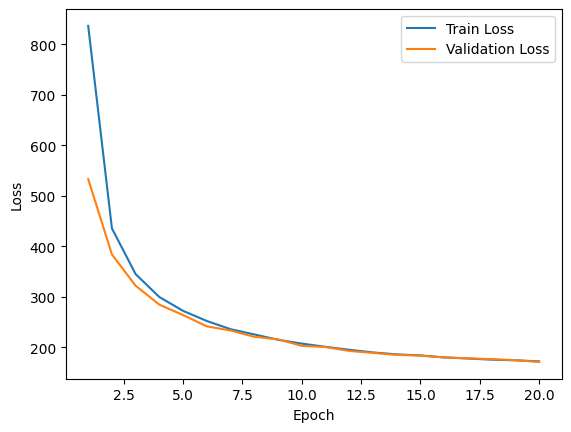

In [17]:
train_vae(model_vae, train_loader, val_loader, optimizer, num_epochs=20, device=device)

In [18]:
def train(model, train_loader, optimizer, device):  
    model.train() 
    total_loss = 0.0
    for batch in train_loader:
        input_data, _ = batch
        input_data = input_data.to(device)

        optimizer.zero_grad()
        reconstructed, mu, log_sigma = model(input_data) 
        loss = loss_function(input_data, reconstructed, mu, log_sigma) #Tính toán tổn thất loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss

def validate(model, val_loader, device):  
    model.eval() #tắt Dropout
    total_loss = 0.0
    with torch.no_grad(): #Tính toán tổn thất trên tập kiểm định mà không cần gradient 
        for val_batch in val_loader:
            val_data, _ = val_batch
            val_data = val_data.to(device)
            val_reconstructed, val_mu, val_log_sigma = model(val_data)
            val_loss = loss_function(val_data, val_reconstructed, val_mu, val_log_sigma)

            total_loss += val_loss.item()

    avg_loss = total_loss / len(val_loader.dataset)
    return avg_loss

def test(model, test_loader, device): #Tính toán tổn thất trên tập dữ liệu kiểm tra
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for test_batch in test_loader:
            test_data, _ = test_batch
            test_data = test_data.to(device)
            test_reconstructed, test_mu, test_log_sigma = model(test_data)
            test_loss = model.loss_function(test_data, test_reconstructed, test_mu, test_log_sigma)
            total_loss += test_loss.item()

    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

#def train_vae(model, train_loader, val_loader, optimizer, num_epochs=20, device="cpu"):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, device)
        val_loss = validate(model, val_loader, device)
        #test_loss = test(model, test_loader, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        #test_losses.append(test_loss)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Plotting the training and validation loss curves
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    #plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Train the VAE model
#train_vae(model_vae, train_loader, val_loader, optimizer, num_epochs=10, device=device)

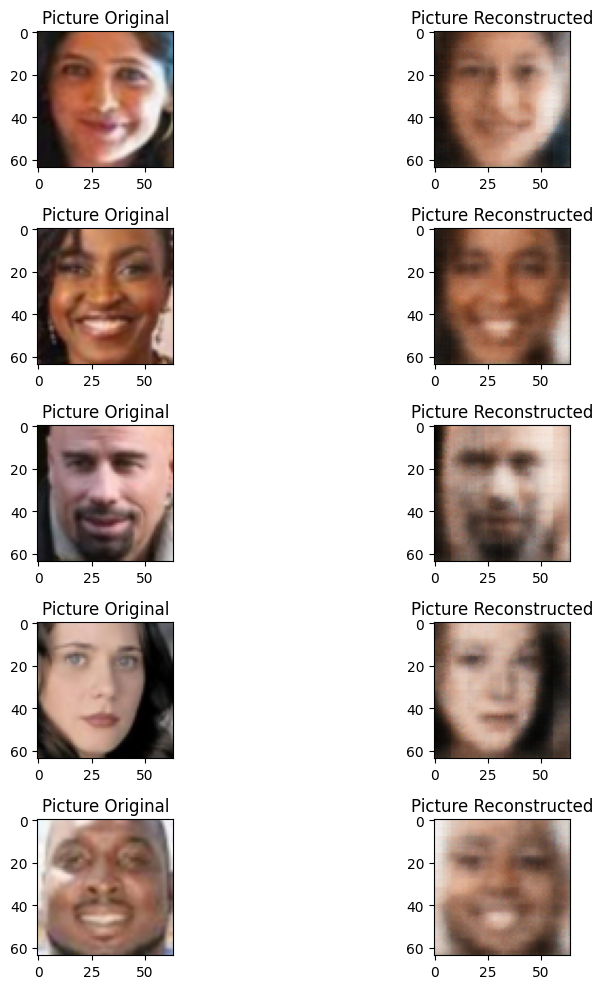

<Figure size 2000x2000 with 0 Axes>

In [19]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Function to visualize original and reconstructed images
def visualize_reconstructions(model, test_loader, device, num_images=5):
    model.eval() #tắt Dropout or BatchNorm 
    with torch.no_grad():
        fig, axes = plt.subplots(num_images, 2, figsize=(10, 2*num_images))
        for i, (data, _) in enumerate(test_loader):
            if i == num_images:
                break
            # tensor PyTorch (C x H x W) sang mảng NumPy (H x W x C)
            original_img = data[0].permute(1, 2, 0).cpu().numpy()  # Original image
            reconstructed_img, _, _ = model(data.to(device))       #Bỏ qua mean và log variance
            reconstructed_img = reconstructed_img[0].permute(1, 2, 0).cpu().numpy()  # Reconstructed image 
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title('Picture Original')
            axes[i, 1].imshow(reconstructed_img)
            axes[i, 1].set_title('Picture Reconstructed')
        plt.tight_layout()
        plt.figure(dpi=200, figsize=(10, 10))
        plt.show()

visualize_reconstructions(model_vae, test_loader, device)

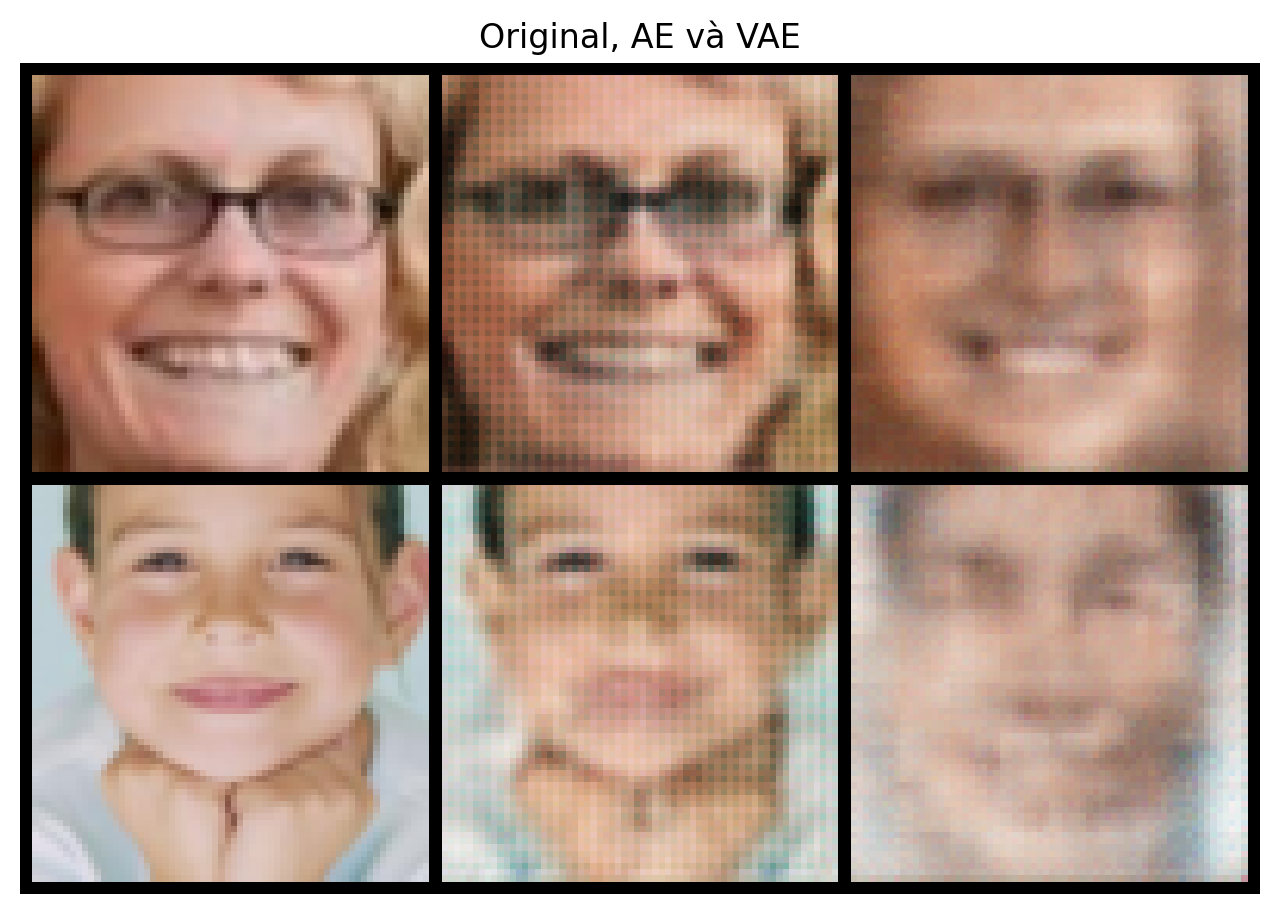

In [20]:
#Lấy mẫu ngẫu nhiên một điểm từ không gian tiềm ẩn của VAE và so sánh
images, labels = get_random_images(dataset, 2) # Lấy 2 hình ảnh ngẫu nhiên
with torch.no_grad():
    imgs_to_display = []
    for i in range(2): # Duyệt qua 2 hình ảnh
        original_image = images[i].unsqueeze(dim=0).to(device)    
        reconstructed_image_ae = model_ae(original_image).view(-1, 3, 64, 64)
        reconstructed_image_vae, _, _ = model_vae(original_image)
        reconstructed_image_vae = reconstructed_image_vae.view(-1, 3, 64, 64)
        imgs_to_display.extend([original_image, reconstructed_image_ae, reconstructed_image_vae])

# Tạo một lưới từ danh sách hình ảnh để hiển thị
imgs = torch.stack(imgs_to_display, dim=1).flatten(0, 1)
grid = torchvision.utils.make_grid(imgs, nrow=3) # Mỗi hàng sẽ có 3 hình ảnh: gốc, tái tạo từ AE và VAE
grid = grid.permute(1, 2, 0)

plt.figure(dpi=200, figsize=(8, 6))
plt.title('Original, AE và VAE')
plt.imshow(grid.cpu())
plt.axis('off')
plt.show()

# Vẽ đồ thị t-SNE của AE và VAE 

In [21]:
#Vẽ đồ thị t-SNE của AE VAE 
#trực quan hóa dữ liệu high-dimensional vào một không gian lower-dimensional, 
from sklearn.manifold import TSNE
import seaborn as sns

def tsne2d_plot(data, labels, title = '2D t-SNE Plot'):
    
    tsne = TSNE(n_components = 2)

    projections = pd.DataFrame(tsne.fit_transform(data))
    projections['gender'] = labels.astype(str)

    plt.figure(figsize=(8, 6))
    b = sns.scatterplot(

        projections,
        x = 0,
        y = 1,
        hue = 'gender'
    )
    
    plt.title(title)
    plt.show()

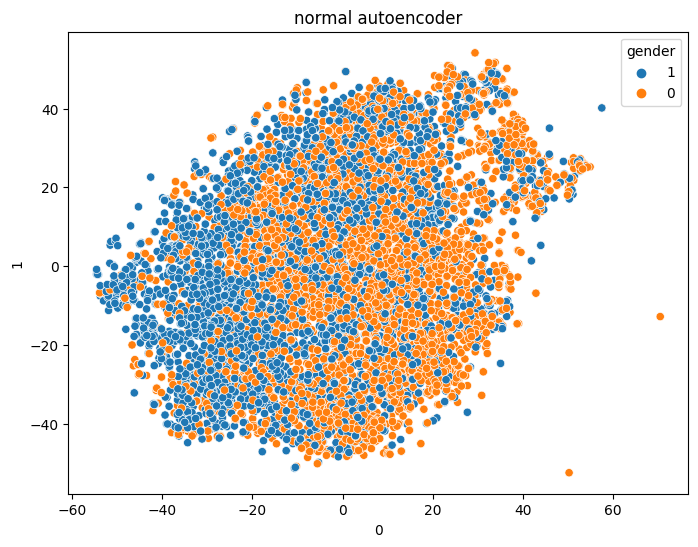

In [22]:
# mã hóa của mô hình AE để lấy mã hóa latent
latent_codes = []
labels_list = []

for _, (images,labels) in enumerate(test_loader): #lấy images và nhãn tương ứng labels cho đến khi đạt đến batch thứ 100
    if _ == 100:
        break   
    images = images.to(device)
    with torch.no_grad(): 
        latent_code = model_ae.encoder_conv(images)

    latent_codes.append(latent_code.view(latent_code.size(0), -1).cpu().numpy())
    labels_list.extend(labels.cpu().numpy())

latent_codes = np.concatenate(latent_codes, axis = 0)  # tạo ra một ma trận, trong đó mỗi hàng đại diện cho mã hóa latent của một hình ảnh.
labels_list = np.array(labels_list)

tsne2d_plot(latent_codes,labels_list,title='normal autoencoder')

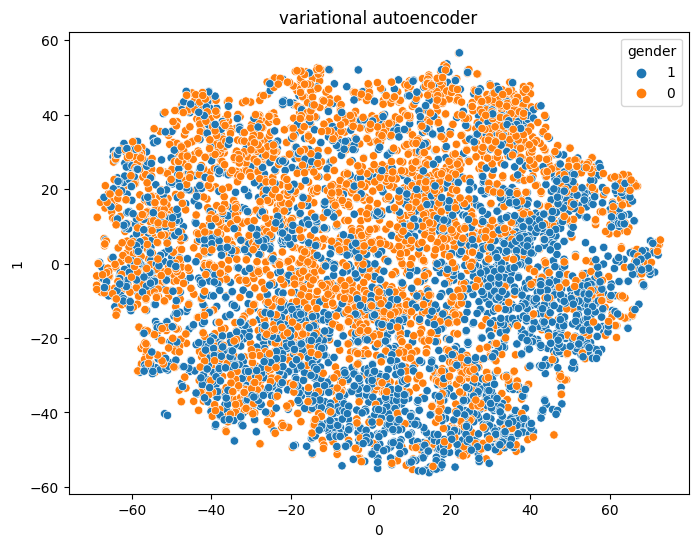

In [23]:
latent_codes = []
labels_list = []

for _, (images,labels) in enumerate(test_loader):
    
    if _ == 100:
        
        break
        
    images = images.to(device)
    
    with torch.no_grad():
        
        latent_code = model_vae.encoder_conv(images)

    latent_codes.append(latent_code.view(latent_code.size(0), -1).cpu().numpy())
    labels_list.extend(labels.cpu().numpy())

latent_codes = np.concatenate(latent_codes, axis = 0)
labels_list = np.array(labels_list)

tsne2d_plot(latent_codes,labels_list,title='variational autoencoder')

# Smoothness of Latent Space

In [24]:
# Smoothness of Latent Space
images, labels = get_random_images(dataset, 2)
plt.figure(figsize=(4, 4))  # Đặt kích thước hình ảnh bạn muốn hiển thị
plt.imshow(images[0].permute(1, 2, 0))  # Sắp xếp lại các kênh màu và hiển thị hình ảnh
plt.title(f'Image 1 - Label: {labels[0]}')  # Đặt tiêu đề, nếu bạn muốn hiển thị nhãn
plt.axis('off')  # Tắt các trục
plt.show()

# Hiển thị hình ảnh thứ hai
plt.figure(figsize=(4, 4))
plt.imshow(images[1].permute(1, 2, 0))
plt.title(f'Image 2 - Label: {labels[1]}')
plt.axis('off')
plt.show()
with torch.no_grad():
    image1 = images[0].unsqueeze(dim = 0).to(device)
    image2 = images[1].unsqueeze(dim = 0).to(device)
    #r ảnh tái tạo, mu trung bình không gian latent, sigma độ lệch chuẩn
    r_1,mu_1,sigma_1 = model_vae(image1)  
    r_2,mu_2,sigma_2 = model_vae(image2)

    #tính toán mean và log var
    temp_1 = model_vae.encoder_conv(image1)
    temp_1 = model_vae.flatten(temp_1)
    mean = model_vae.mean(temp_1) 
    log_var = model_vae.log_var(temp_1)
    latent_1 = model_vae.reparameterization_trick(mean, torch.exp(0.5 * log_var))  #sử dụng một "trick" tái tham số hóa
    temp_2 = model_vae.encoder_conv(image2)
    temp_2 = model_vae.flatten(temp_2)
    mean = model_vae.mean(temp_2)
    log_var = model_vae.log_var(temp_2)
    latent_2 = model_vae.reparameterization_trick(mean, torch.exp(0.5 * log_var))    
    
    i_5 = 0.1 * latent_1 + 0.9 * latent_2
    i_4 = 0.3 * latent_1 + 0.7 * latent_2
    i_3 = 0.5 * latent_1 + 0.5 * latent_2
    i_2 = 0.7 * latent_1 + 0.3 * latent_2
    i_1 = 0.9 * latent_1 + 0.1 * latent_2

    i_1 = model_vae.unflatten(i_1) #tái cấu trúc thành tensor có dạng phù hợp
    ii_1 = model_vae.decoder_conv(i_1) #đưa qua lớp convolutional decoder layers
    
    i_2 = model_vae.unflatten(i_2)
    ii_2 = model_vae.decoder_conv(i_2)
    
    i_3 = model_vae.unflatten(i_3)
    ii_3 = model_vae.decoder_conv(i_3)
    
    i_4 = model_vae.unflatten(i_4)
    ii_4 = model_vae.decoder_conv(i_4)
    
    i_5 = model_vae.unflatten(i_5)
    ii_5 = model_vae.decoder_conv(i_5)

imgs = torch.stack([r_1.view(-1, 3, 64, 64),
                    ii_1.view(-1, 3, 64, 64),
                    ii_2.view(-1, 3, 64, 64),
                    ii_3.view(-1, 3, 64, 64),
                    ii_4.view(-1, 3, 64, 64),
                    ii_5.view(-1, 3, 64, 64),
                    r_2.view(-1, 3, 64, 64) ],dim=1).flatten(0,1)  # làm phẳng

grid = torchvision.utils.make_grid(imgs, nrow = 7)
grid = grid.permute(1, 2, 0)
plt.figure(dpi = 200, figsize = (10,6))
plt.title('smoothness of latent space in the variational autoencoder')
plt.imshow(grid.cpu())
plt.axis('off')
plt.show()
#ELBO là một phần của hàm mất mát trong VAE, cách tính điểm:
# giá trị ELBO thấp hơn cho thấy mô hình tái tạo dữ liệu tốt hơn gần với phân phối chuẩn hơn
elbo_i11 = loss_function(r_1,ii_1,mu_1,sigma_1)
elbo_i12 = loss_function(r_1,ii_2,mu_1,sigma_1)
elbo_i13 = loss_function(r_1,ii_3,mu_1,sigma_1)
elbo_i14 = loss_function(r_1,ii_4,mu_1,sigma_1)
elbo_i15 = loss_function(r_1,ii_5,mu_1,sigma_1)

elbo_i21 = loss_function(r_2,ii_1,mu_2,sigma_2
elbo_i22 = loss_function(r_2,ii_2,mu_2,sigma_2)
elbo_i23 = loss_function(r_2,ii_3,mu_2,sigma_2)
elbo_i24 = loss_function(r_2,ii_4,mu_2,sigma_2)
elbo_i25 = loss_function(r_2,ii_5,mu_2,sigma_2)
# tăng là khi đi từ sample 1 đến sample 2 khó khăn hơn
print("ELBO (Sample 1)")
print()
print("interpolation 1 = ", elbo_i11.item())
print("interpolation 2 = ", elbo_i12.item())
print("interpolation 3 = ", elbo_i13.item())
print("interpolation 4 = ", elbo_i14.item())
print("interpolation 5 = ", elbo_i15.item())
print()
print("ELBO (Sample 2)")
print()
print("interpolation 1 = ", elbo_i21.item())
print("interpolation 2 = ", elbo_i22.item())
print("interpolation 3 = ", elbo_i23.item())
print("interpolation 4 = ", elbo_i24.item())
print("interpolation 5 = ", elbo_i25.item())
print()

SyntaxError: '(' was never closed (2897508739.py, line 78)

In [ ]:
images, labels = get_random_images(dataset, 2)
plt.figure(figsize=(4, 4))  # Đặt kích thước hình ảnh bạn muốn hiển thị
plt.imshow(images[0].permute(1, 2, 0))  # Sắp xếp lại các kênh màu và hiển thị hình ảnh
plt.title(f'Image 1 - Label: {labels[0]}')  # Đặt tiêu đề, nếu bạn muốn hiển thị nhãn
plt.axis('off')  # Tắt các trục
plt.show()

# Hiển thị hình ảnh thứ hai
plt.figure(figsize=(4, 4))
plt.imshow(images[1].permute(1, 2, 0))
plt.title(f'Image 2 - Label: {labels[1]}')
plt.axis('off')
plt.show()
grid = torchvision.utils.make_grid(imgs, nrow = 7)
grid = grid.permute(1, 2, 0)
with torch.no_grad():

    image1 = images[0].unsqueeze(dim = 0).to(device)
    image2 = images[1].unsqueeze(dim = 0).to(device)
        
    r_1,mu_1,sigma_1 = model_vae(image1)
    r_2,mu_2,sigma_2 = model_vae(image2)

    temp_1 = model_vae.encoder_conv(image1)
    temp_1 = model_vae.flatten(temp_1)
    mean = model_vae.mean(temp_1)
    log_var = model_vae.log_var(temp_1)
    latent_1 = model_vae.reparameterization_trick(mean, torch.exp(0.5 * log_var))

    temp_2 = model_vae.encoder_conv(image2)
    temp_2 = model_vae.flatten(temp_2)
    mean = model_vae.mean(temp_2)
    log_var = model_vae.log_var(temp_2)
    latent_2 = model_vae.reparameterization_trick(mean, torch.exp(0.5 * log_var))    

    i_5 = 0.1 * latent_1 + 0.9 * latent_2
    i_4 = 0.3 * latent_1 + 0.7 * latent_2
    i_3 = 0.5 * latent_1 + 0.5 * latent_2
    i_2 = 0.7 * latent_1 + 0.3 * latent_2
    i_1 = 0.9 * latent_1 + 0.1 * latent_2

    i_1 = model_vae.unflatten(i_1)
    ii_1 = model_vae.decoder_conv(i_1)
    
    i_2 = model_vae.unflatten(i_2)
    ii_2 = model_vae.decoder_conv(i_2)
    
    i_3 = model_vae.unflatten(i_3)
    ii_3 = model_vae.decoder_conv(i_3)
    
    i_4 = model_vae.unflatten(i_4)
    ii_4 = model_vae.decoder_conv(i_4)
    
    i_5 = model_vae.unflatten(i_5)
    ii_5 = model_vae.decoder_conv(i_5)

imgs = torch.stack([r_1.view(-1, 3, 64, 64),
                    ii_1.view(-1, 3, 64, 64),
                    ii_2.view(-1, 3, 64, 64),
                    ii_3.view(-1, 3, 64, 64),
                    ii_4.view(-1, 3, 64, 64),
                    ii_5.view(-1, 3, 64, 64),
                    r_2.view(-1, 3, 64, 64) ],dim=1).flatten(0,1)

grid = torchvision.utils.make_grid(imgs, nrow = 7)
grid = grid.permute(1, 2, 0)
plt.figure(dpi = 200, figsize = (10,6))
plt.title('smoothness of latent space in the VAS')
plt.imshow(grid.cpu())
plt.show()

elbo_i11 = loss_function(r_1,ii_1,mu_1,sigma_1)
elbo_i12 = loss_function(r_1,ii_2,mu_1,sigma_1)
elbo_i13 = loss_function(r_1,ii_3,mu_1,sigma_1)
elbo_i14 = loss_function(r_1,ii_4,mu_1,sigma_1)
elbo_i15 = loss_function(r_1,ii_5,mu_1,sigma_1)

elbo_i21 = loss_function(r_2,ii_1,mu_2,sigma_2)
elbo_i22 = loss_function(r_2,ii_2,mu_2,sigma_2)
elbo_i23 = loss_function(r_2,ii_3,mu_2,sigma_2)
elbo_i24 = loss_function(r_2,ii_4,mu_2,sigma_2)
elbo_i25 = loss_function(r_2,ii_5,mu_2,sigma_2)

print("ELBO (Sample 1)")
print()
print("interpolation 1 = ", elbo_i11.item())
print("interpolation 2 = ", elbo_i12.item())
print("interpolation 3 = ", elbo_i13.item())
print("interpolation 4 = ", elbo_i14.item())
print("interpolation 5 = ", elbo_i15.item())
print()
print("ELBO (Sample 2)")
print()
print("interpolation 1 = ", elbo_i21.item())
print("interpolation 2 = ", elbo_i22.item())
print("interpolation 3 = ", elbo_i23.item())
print("interpolation 4 = ", elbo_i24.item())
print("interpolation 5 = ", elbo_i25.item())
print()